# HVeV processing code, Jul 30 2024

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

sys.path.append('../scripts')
from Nexus_RQ import RQ
from Nexus_utils import *   # loader, trigger, Pulse2, glob

# OLAF 11 specific
datadir = '/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/'
filename_pattern = datadir + 'RUN04005_DUMP000*.mid.gz'
#filename_pattern = datadir + 'RUN04005_DUMP*.mid.gz' #0003-0217; will take a while...!
chs = ['PCS1','PFS1','PBS2','PFS2'] # channels to use (which also serve as dictionary keys)
names = ['TAMU_A','TAMU_B','NFH_A','NFH_B']
taus = [[1e-5,3e-4],[1e-5,3e-4], [1e-6,5e-4],[1e-6,5e-4]] # pulse rise/fall times (seconds)
sats = [10,10,10,10] # saturation amplitudes (uA), only for matched filter RQs
#PSDarrays = np.load('olaf11_psds.npy')

# general
fsamp = 625000 # Hz
pretrig = 4096 # bins
posttrig = 4096
tracelen = pretrig + posttrig # trace used for RQ processing
psdfreq = np.fft.rfftfreq(tracelen,1/fsamp)
ADC2A = 1/2**16 *8/5e3 /2.4/4 # 16-bit ADC, 8V range, 5kOhm R_FB, 2.4 turn ratio, gain = 4
# MIDAS
allchs = ['PBS1','PAS1','PCS1','PFS1','PDS1','PES1','PBS2','PFS2','PES2','PAS2','PDS2','PCS2']
colors = ['#00ff00','#ffcc00','#ff00ff','#ff0000','#0000ff','#00ffff','#008000','#808000','#993300','#800080','#3366ff','#ff9900']

# trigger options
randomrate = 0 # random triggers to add per trace
trigger_channels = chs # channels to trigger on
trigger_threshold_uA = [0.05, 0.03, 0.05, 0.05] # in uA
trigger_threshold = [x*1e-6/ADC2A for x in trigger_threshold_uA] # OF amp, in ADCu, to trigger on
deactivation_threshold = [0.5*x for x in trigger_threshold]
window = False # add window function to filtered pulse used for trigger

INFO: Found 1 midas raw data files
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04005_DUMP0008.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04005_DUMP0008.mid.gz
RawDataReader: Extracted series from ODB: 992407122357
RawDataReader: Extracted dump from ODB: 8
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04005_DUMP0008.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04005_DUMP0008.mid.gz
RawDataReader: Extracted series from ODB: 992407122357
RawDataReader: Extracted dump from ODB: 8
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLA

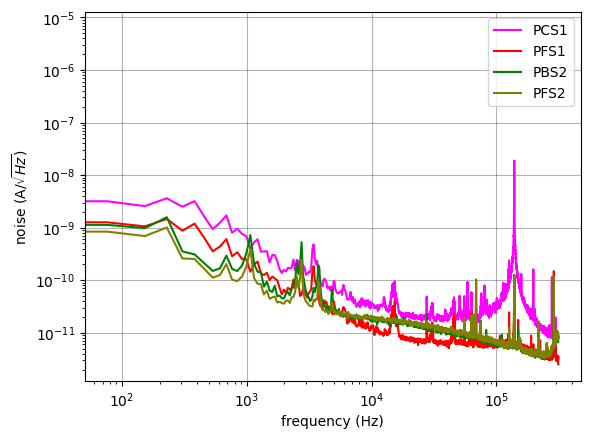

In [2]:
# first, make PSDs
import cdms
fns = glob(filename_pattern)[:1] # limit to the first file
myreader = cdms.rawio.IO.RawDataReader(filepath=fns)
events = myreader.read_events(output_format=1, # pandas
                              skip_empty=True,
                              channel_names=chs,
                              phonon_adctoamps=False) # convert to A manually
series = events.index[0][0]
evs = events.loc[series].index

# get PGAgain (although for us it always = 1)
odb = myreader.get_full_odb()

psds = np.zeros((12,len(psdfreq)))
for ch in chs:
    tes = allchs.index(ch)
    pgagain = odb[f'/Detectors/Det01/Settings/Phonon/DriverPGAGain'][tes]
    psds_tes = []
    for i in range(len(evs)):
        ev = evs[i]
        trace = events.loc[series].loc[ev].loc[('Z1',ch)]
        # must cast to float from uint (or else)
        trace = (np.array(trace,dtype=float)-32768) * ADC2A / pgagain
        # non-robust pulse rejection
        if np.max(trace)-np.min(trace) > 2e-6:
            continue
        psd = np.abs(np.fft.rfft(trace[:tracelen]))
        psds_tes.append(psd)
    if len(psds_tes) > 0:
        psds[tes] = np.median(psds_tes,axis=0)
np.save('olaf11_psds.npy',psds)

# plot
for ch in chs:
    tes = allchs.index(ch)
    psd = psds[tes] * np.sqrt(2.0 / (fsamp*tracelen)) # normalize
    plt.loglog(psdfreq,psd,color=colors[tes],label=ch)
plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel(r'noise (A/$\sqrt{Hz})$')
plt.grid(color='k',alpha=0.3)

In [3]:
# run NEXUS trigger and RQ processing
# options
file_range = None # index range of filenames to use
filerange_low = 0
DATA_TYPE = 'SLAC'

# more setup
t0 = pretrig/fsamp # for positioning trace in middle of template
saturation_amplitude = {}
channel_config = {}
Templates = {}
PSDs = {}
OF_LPF_dict = {}
trigTemplates = []
trigPSDs = []
if 'psds' not in locals():
    print('Loading PSDs')
    psds = np.load('olaf11_psds.npy')
for i in range(len(chs)):
	key = chs[i]
	tes = allchs.index(key)
    # some dictionaries
	saturation_amplitude[key] = sats[i]
	channel_config[key] = {
		'name': names[i],
		'trigger_channel': key,
		'sub_channels': None
	}
    # store PSDs + make pulse templates
	t = np.arange(tracelen)/fsamp # seconds
	Templates[key] = Pulse2(t,*taus[i],t0=0)
	PSDs[key] = psds[tes]
	OF_LPF_dict[key] = -1 #nofilter
	trigTemplates.append(Pulse2(t,*taus[i],t0=t0))
	trigPSDs.append(psds[tes])

In [4]:
# instantiate Reduced Quantity object
rq = RQ(OFP_WINDOW=250,ENABLE_OFP=True,OFL_MAX_DELAY=25,MAX_CHISQ_FREQ_BIN=-1,
		Fs=fsamp,Pretrig=pretrig,Posttrig=posttrig,BaseLength=4086,TailLength=3096,
		ShortChi2Length=200,PlateauDelay=100,PlateauLength=100,UseFilterForRQs=False,
		CutoffFrequenciesForRQs=None,FilterOrderForRQs=10,WindowForPulseRQs=100,
        saturation_amplitude=saturation_amplitude)

In [5]:
# make Optimal Filter
#  calling a private function smh...
rq._make_filter_kernel_OF(Templates, PSDs, OF_LPF_dict=OF_LPF_dict)

In [6]:
# now calculate RQs!
#  first prepare to load MIDAS data
ld = loader(filename_pattern=filename_pattern,file_range=file_range,data_type=DATA_TYPE,keylist=chs)
#  process files one by one - first find traces that pass trigger criteria, then call rq's `process_traces`
for i_file in range(len(ld.file_list)):
	print(f"Processing file #_{filerange_low+i_file}, {i_file+1}/{len(ld.file_list)}")
	res=ld.load_next_nfiles(1)
	tg = trigger(res, channel_config, trigger_channels, trigger_threshold, deactivation_threshold=deactivation_threshold,
        TTL_THRESHOLD=300, INRUN_RANDOM=randomrate,
        WINDOW_TEMPLATE=window, USE_GAUS_KERNEL=False, BYPASS_HIGH_ENERGY_IN_FILTER=False,
        trigger_type=1, align_max=True, filter_kernels=trigTemplates, PSD=trigPSDs, OF_LPF=-1,
		pre_trig=pretrig, post_trig=posttrig, pre_trig_kernel=4096, post_trig_kernel=4096, fs=fsamp,
		keep_metadata=True, verbose=True, use_ttl_falling_edge=False, remove_trigger_offset=False, ADC2A=ADC2A)
	Traces, trigger_result_new = tg.run_trigger()
	n_events=len(trigger_result_new["trig_loc"])
	print(f"  {n_events} events triggered,")

	print("   Calculating RQs...")
	RQ_new = rq.process_traces(Traces, trigger_result_new)
	RQ_new["trig_fileidx"] = np.repeat(filerange_low+i_file, n_events).astype(np.int16)

	if i_file==0:
		trigger_result = trigger_result_new
		RQs = RQ_new
	else:
		trigger_result = append_dicts(trigger_result,trigger_result_new)
		RQs= append_dicts(RQs, RQ_new)

	for ch in np.unique(trigger_result_new["trig_ch"]):
		print("	* ",ch, sum(trigger_result_new["trig_ch"]==ch))
	

# Combine RQ with trigger info, save
for key in trigger_result:
	RQs[key]=trigger_result[key]




Processing file #_0, 1/7
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04005_DUMP0003.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04005_DUMP0003.mid.gz
RawDataReader: Extracted series from ODB: 992407122357
RawDataReader: Extracted dump from ODB: 3
INFO: Found 1 midas raw data files
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04005_DUMP0003.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF11/RUN04005_DUMP0003.mid.gz
RawDataReader: Extracted series from ODB: 992407122357
RawDataReader: Extracted dump from ODB: 3
  Setting threshold for PCS1: 19.6

In [7]:
'''
# helper pickle functions
import pickle

# save
with open('4005.pkl','wb') as fp:
    pickle.dump(RQs,fp)

def combineRQs(oldRQs,newRQs):
    keys = oldRQs.keys()
    if len(keys) == 0:
        keys = newRQs.keys()
    for key in keys:
        if key in oldRQs:
            oldRQs[key] = np.append(oldRQs[key],newRQs[key])
        else:
            oldRQs[key] = newRQs[key]

# load
RQs = {}
for rn in ['4005']:
    with open(f'{rn}.pkl','rb') as fp:
        rRQs = pickle.load(fp)
        combineRQs(RQs,rRQs)
'''

"\n# helper pickle functions\nimport pickle\n\n# save\nwith open('4005.pkl','wb') as fp:\n    pickle.dump(RQs,fp)\n\ndef combineRQs(oldRQs,newRQs):\n    keys = oldRQs.keys()\n    if len(keys) == 0:\n        keys = newRQs.keys()\n    for key in keys:\n        if key in oldRQs:\n            oldRQs[key] = np.append(oldRQs[key],newRQs[key])\n        else:\n            oldRQs[key] = newRQs[key]\n\n# load\nRQs = {}\nfor rn in ['4005']:\n    with open(f'{rn}.pkl','rb') as fp:\n        rRQs = pickle.load(fp)\n        combineRQs(RQs,rRQs)\n"

In [8]:
# list RQ names
print(RQs.keys())

dict_keys(['OF0_A_PCS1', 'OF0_chi2_PCS1', 'OF_A_PCS1', 'OF_chi2_PCS1', 'OF_time_PCS1', 'OFL_A_PCS1', 'OFL_chi2_PCS1', 'OFL_time_PCS1', 'MF_PCS1', 'Amplitude_PCS1', 'Max_PCS1', 'MaxHead_PCS1', 'MaxTail_PCS1', 'Integral_PCS1', 'IntegralHead_PCS1', 'IntegralTail_PCS1', 'BaselineSlope_PCS1', 'Slope_PCS1', 'PlateauAmplitude_PCS1', 'RiseTime1_PCS1', 'RiseTime2_PCS1', 'RiseTime3_PCS1', 'FallTime1_PCS1', 'FallTime2_PCS1', 'FallTime3_PCS1', 'PulseWidth50_PCS1', 'PulseMaxInd_PCS1', 'MeanBase_PCS1', 'BaselineVariance_PCS1', 'TailVariance_PCS1', 'OF0_A_PFS1', 'OF0_chi2_PFS1', 'OF_A_PFS1', 'OF_chi2_PFS1', 'OF_time_PFS1', 'OFL_A_PFS1', 'OFL_chi2_PFS1', 'OFL_time_PFS1', 'MF_PFS1', 'Amplitude_PFS1', 'Max_PFS1', 'MaxHead_PFS1', 'MaxTail_PFS1', 'Integral_PFS1', 'IntegralHead_PFS1', 'IntegralTail_PFS1', 'BaselineSlope_PFS1', 'Slope_PFS1', 'PlateauAmplitude_PFS1', 'RiseTime1_PFS1', 'RiseTime2_PFS1', 'RiseTime3_PFS1', 'FallTime1_PFS1', 'FallTime2_PFS1', 'FallTime3_PFS1', 'PulseWidth50_PFS1', 'PulseMaxInd_P

PCS1 19.087011
PFS1 -0.05285556
PBS2 -0.053906173
PFS2 38.238018


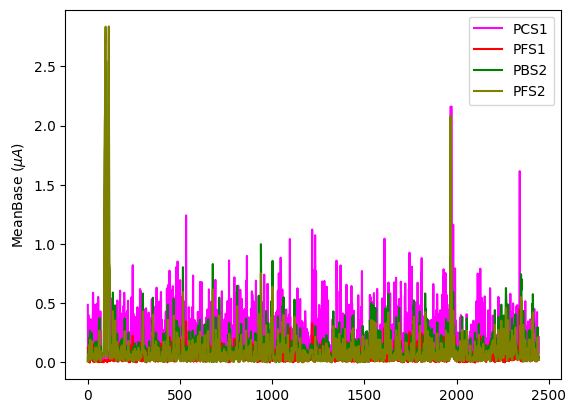

In [9]:
# plot baselines

for ch in chs:
    xkey = f'MeanBase_{ch}' # Baseline
    x = RQs[xkey]*1e6
    plt.plot(x-np.min(x),color=colors[allchs.index(ch)],label=ch)
    print(ch,np.min(x))
plt.ylabel('MeanBase ($\mu A$)')
plt.legend()


Text(0, 0.5, 'OF_chi2_PFS1')

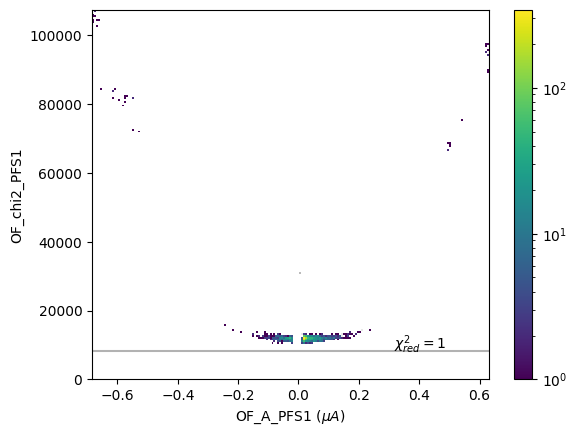

In [10]:
# plot single-channel chi2 vs OFA

ch = 'PFS1'

xkey = f'OF_A_{ch}' # Amplitude (t-dep)
ykey = f'OF_chi2_{ch}' # chi2 (t-dep)
x = RQs[xkey]*1e6
y = RQs[ykey]

# cuts?
baseline = RQs[f'MeanBase_{ch}']*1e6
cuts = (baseline < 0.1) # cut mask

# bins
bins = (np.linspace(min(x),max(x),200),np.linspace(0,max(y),200))
plt.hist2d(x,y,bins=bins,cmap='binary',norm=LogNorm(),alpha=0.8)
plt.hist2d(x[cuts],y[cuts],bins=bins,norm=LogNorm())
# chi2 ~ number of data points in trace (8192)
plt.axhline(tracelen,color='k',alpha=0.3)
plt.text(bins[0][-1]*0.5,9000,r'$\chi^2_{red}=1$')
plt.colorbar()
plt.xlabel(xkey+r' ($\mu A$)')
plt.ylabel(ykey)


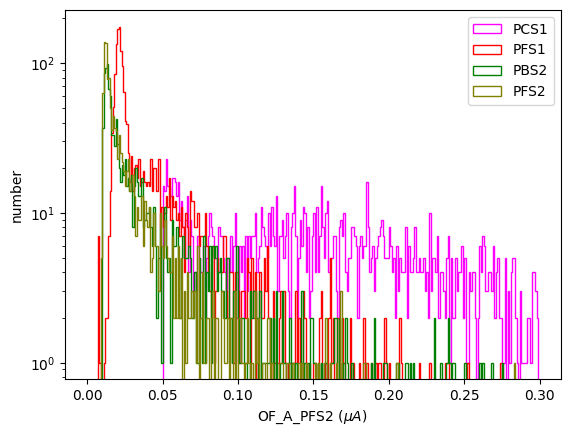

In [11]:
# plot 1D amplitude histograms

# bins
#bins = np.linspace(0,max(x),200)
bins = np.arange(0,0.3,0.001)
for ch in chs:
    xkey = f'OF_A_{ch}' # Amplitude (t-dep)
    x = RQs[xkey]*1e6
    plt.hist(x,bins=bins,histtype='step',color=colors[allchs.index(ch)],label=ch)
plt.xlabel(xkey+r' ($\mu A$)')
plt.ylabel('number')
plt.yscale('log')
plt.legend()


Text(0, 0.5, 'OF_A_PFS1 ($\\mu A$)')

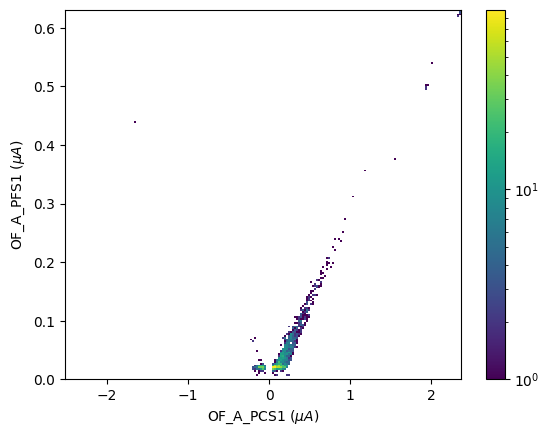

In [12]:
# plot OFA vs OFA2

ch = 'PCS1' #'PBS2'
ch2= 'PFS1'

xkey = f'OF_A_{ch}'
ykey = f'OF_A_{ch2}'
x = RQs[xkey]*1e6
y = RQs[ykey]*1e6

#bins
bins = (np.linspace(min(x),max(x),200),np.linspace(0,max(y),200))

plt.hist2d(x,y,bins=bins,norm=LogNorm())
plt.colorbar()
plt.xlabel(xkey+r' ($\mu A$)')
plt.ylabel(ykey+r' ($\mu A$)')